In [5]:
import pandas as pd  # Source: McKinney, Wes. Python for Data Analysis. O'Reilly Media, 2017
import numpy as np  # Source: Harris et al., Array programming with NumPy, Nature 2020
from sklearn.linear_model import LinearRegression, Lasso  # Source: Pedregosa et al., Scikit-learn: Machine Learning in Python, JMLR 2011
from sklearn.feature_selection import RFE  # Source: Pedregosa et al., Scikit-learn: Machine Learning in Python, JMLR 2011
from sklearn.ensemble import RandomForestRegressor  # Source: Pedregosa et al., Scikit-learn: Machine Learning in Python, JMLR 2011
from sklearn.svm import SVR  # Source: Pedregosa et al., Scikit-learn: Machine Learning in Python, JMLR 2011
import lightgbm as lgb  # Source: Ke et al., LightGBM: A Highly Efficient Gradient Boosting Decision Tree, NIPS 2017
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Source: Pedregosa et al., Scikit-learn: Machine Learning in Python, JMLR 2011
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
import matplotlib.pyplot as plt  # Source: Hunter, J.D., Matplotlib: A 2D graphics environment, Computing in Science & Engineering, 2007

## Feature Selection

In [6]:
# Step 1: Loadig Dataset
X_train = pd.read_csv('Train_Test_Data/X_train_engineered.csv')
y_train = pd.read_csv('Train_Test_Data/y_train_engineered.csv')

In [7]:
# Step 2: Apply RFE with Linear Regression
linear_model = LinearRegression()
rfe_selector_lr = RFE(estimator=linear_model, n_features_to_select=10, step=1)
rfe_selector_lr.fit(X_train, y_train.values.ravel()) # .values.ravel() = setting targetvariable to one-dimensional array

# Save selected features after RFE with Linear Regression
selected_features_rfe_lr = X_train.columns[rfe_selector_lr.support_] # Boolean array to get the names of the selected features out of X_train
print("\nSelected features after RFE with Linear Regression:")
print(selected_features_rfe_lr)

# Step 3: Apply RFE with SVR
svr_model = SVR(kernel='linear')  # Using a linear kernel for feature selection
rfe_selector_svr = RFE(estimator=svr_model, n_features_to_select=10, step=1) 
rfe_selector_svr.fit(X_train, y_train.values.ravel())

# Save selected features after RFE with SVR
selected_features_rfe_svr = X_train.columns[rfe_selector_svr.support_]
print("\nSelected features after RFE with SVR:")
print(selected_features_rfe_svr)

# Step 4: Apply Lasso for Linear Regression
lasso_model = Lasso(alpha=0.01)  # adjust alpha to increase/decrease strength of regulation
lasso_model.fit(X_train, y_train.values.ravel())

# Save selected features after Lasso
selected_features_lasso = X_train.columns[lasso_model.coef_ != 0] # select features with non-zero coefficients. In Lasso they are considered irrelevant.
print("\nSelected features after Lasso:")
print(selected_features_lasso)


Selected features after RFE with Linear Regression:
Index(['ProductionVolume', 'SupplierQuality', 'StockoutRate',
       'EnergyConsumption', 'EnergyEfficiency',
       'ProductionVolume SupplierQuality', 'SupplierQuality^2',
       'SupplierQuality MaintenanceHoursPerDay', 'ProductionEfficiency',
       'EnergyEfficiency_MultipleFactors'],
      dtype='object')

Selected features after RFE with SVR:
Index(['ProductionVolume', 'MaintenanceHours', 'DowntimePercentage',
       'StockoutRate', 'EnergyConsumption', 'EnergyEfficiency',
       'ProductionVolume SupplierQuality',
       'SupplierQuality MaintenanceHoursPerDay', 'ProductionEfficiency',
       'EnergyEfficiency_MultipleFactors'],
      dtype='object')

Selected features after Lasso:
Index(['ProductionVolume', 'ProductionCost', 'DeliveryDelay', 'QualityScore',
       'MaintenanceHours', 'DowntimePercentage', 'InventoryTurnover',
       'WorkerProductivity', 'SafetyIncidents', 'EnergyConsumption',
       'AdditiveProcessTime', '

#### Visualize Feature Selection (Lasso & RFE)

In [60]:
# # Create a DataFrame for selected features from RFE with Linear Regression
# # selected_features_rfe_lr = X_train.columns[rfe_selector_lr.support_]
# importance_lr = pd.Series([1]*len(selected_features_rfe_lr), index=selected_features_rfe_lr)  # Assigning a value of 1 to each feature to represent selection

# plt.figure(figsize=(10, 6))
# importance_lr.sort_values().plot(kind='barh', color='skyblue')
# plt.xlabel('Importance (Selected by RFE)')
# plt.title('Selected Features using RFE with Linear Regression')
# plt.show()

# # Create a DataFrame for selected features from RFE with SVR
# # selected_features_rfe_svr = X_train.columns[rfe_selector_svr.support_]
# importance_svr = pd.Series([1]*len(selected_features_rfe_svr), index=selected_features_rfe_svr)  # Assigning a value of 1 to each feature to represent selection

# plt.figure(figsize=(10, 6))
# importance_svr.sort_values().plot(kind='barh', color='lightgreen')
# plt.xlabel('Importance (Selected by RFE)')
# plt.title('Selected Features using RFE with SVR')
# plt.show()

# Model Training

#### Preparing Data for Model Training

In [8]:
# Load the selected features for training and testing
X_train_rfe_lr = X_train[selected_features_rfe_lr]  # Using selected features from RFE with Linear Regression
X_train_rfe_svr = X_train[selected_features_rfe_svr]  # Using selected features from RFE with SVR
X_train_lasso = X_train[selected_features_lasso]  # Using selected features from Lasso

# Load test set (assuming test set is already available)
X_test = pd.read_csv('Train_Test_Data/X_test_engineered.csv')
y_test = pd.read_csv('Train_Test_Data/y_test_engineered.csv')

X_test_rfe_lr = X_test[selected_features_rfe_lr]
X_test_rfe_svr = X_test[selected_features_rfe_svr]
X_test_lasso = X_test[selected_features_lasso]

#### Defining Models

In [9]:
# Define models
models = {
    'Linear Regression (RFE with LR)': LinearRegression(),
    'Linear Regression (Lasso)': LinearRegression(),
    'SVR (RFE with SVR)': SVR(),
    'Random Forest (Full Dataset)': RandomForestRegressor(random_state=42),
    'LightGBM (Full Dataset)': lgb.LGBMRegressor(random_state=42)
}

#### Training and Evaluation Function using cross-validation

In [10]:
# Function to train and evaluate models using cross-validation
def train_and_evaluate(models, X_train, y_train, cv=5):
    results = {}
    for model_name, model in models.items():
        # Train the model using cross-validation
        print(f"Training {model_name} with cross-validation...")
        mae_scores = -cross_val_score(model, X_train, y_train.values.ravel(), cv=cv, scoring='neg_mean_absolute_error')
        rmse_scores = -cross_val_score(model, X_train, y_train.values.ravel(), cv=cv, scoring='neg_root_mean_squared_error')
        r2_scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=cv, scoring='r2')
        
        # Calculate average metrics
        mae = mae_scores.mean()
        rmse = rmse_scores.mean()
        r2 = r2_scores.mean()
        
        # Store results
        results[model_name] = {
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2
        }
    return results

#### Model Training and Evaluation

In [11]:
# Train and evaluate Linear Regression and SVR on selected features
print("\nEvaluating Linear Regression and SVR on selected features...")
results_lr_rfe = train_and_evaluate({'Linear Regression (RFE with LR)': models['Linear Regression (RFE with LR)']}, X_train_rfe_lr, y_train)
results_lr_lasso = train_and_evaluate({'Linear Regression (Lasso)': models['Linear Regression (Lasso)']}, X_train_lasso, y_train)
results_svr_rfe = train_and_evaluate({'SVR (RFE with SVR)': models['SVR (RFE with SVR)']}, X_train_rfe_svr, y_train)

# Train and evaluate Random Forest and LightGBM on the full dataset
print("\nEvaluating Random Forest and LightGBM on the full engineered dataset...")
results_rf_lgb = train_and_evaluate({'Random Forest (Full Dataset)': models['Random Forest (Full Dataset)'], 'LightGBM (Full Dataset)': models['LightGBM (Full Dataset)']}, X_train, y_train)


Evaluating Linear Regression and SVR on selected features...
Training Linear Regression (RFE with LR) with cross-validation...
Training Linear Regression (Lasso) with cross-validation...
Training SVR (RFE with SVR) with cross-validation...

Evaluating Random Forest and LightGBM on the full engineered dataset...
Training Random Forest (Full Dataset) with cross-validation...
Training LightGBM (Full Dataset) with cross-validation...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5443
[LightGBM] [Info] Number of data points in the train set: 2073, number of used features: 26
[LightGBM] [Info] Start training from score 2.722736
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


#### Results

In [12]:
# Display results
print("\nResults on Selected Features for Linear Regression and SVR:")
for model_name, metrics in {**results_lr_rfe, **results_lr_lasso, **results_svr_rfe}.items():
    print(f"{model_name}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, R²={metrics['R²']:.4f}")

print("\nResults on Full Engineered Dataset for Random Forest and LightGBM:")
for model_name, metrics in results_rf_lgb.items():
    print(f"{model_name}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, R²={metrics['R²']:.4f}")


Results on Selected Features for Linear Regression and SVR:
Linear Regression (RFE with LR): MAE=1.1385, RMSE=1.3133, R²=-0.0049
Linear Regression (Lasso): MAE=1.1389, RMSE=1.3133, R²=-0.0048
SVR (RFE with SVR): MAE=1.1438, RMSE=1.3243, R²=-0.0220

Results on Full Engineered Dataset for Random Forest and LightGBM:
Random Forest (Full Dataset): MAE=1.1550, RMSE=1.3375, R²=-0.0422
LightGBM (Full Dataset): MAE=1.1821, RMSE=1.3814, R²=-0.1119


# Hyperparameter Tuning

In [13]:
# Define parameter grids for each model
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

param_grid_svr = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Type of kernel used in SVR
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf'
}

param_grid_lgb = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage used in updates
    'max_depth': [5, 10, 15],  # Maximum tree depth for base learners
    'num_leaves': [20, 31, 50]  # Maximum number of leaves in one tree
}

# Set up the RandomizedSearchCV for each model
random_search_rf = RandomizedSearchCV(
    estimator=models['Random Forest (Full Dataset)'],
    param_distributions=param_grid_rf,
    n_iter=10,  # Number of random settings to sample
    cv=3,  # Cross-validation folds
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1  # Use all available cores
)

random_search_svr = RandomizedSearchCV(
    estimator=models['SVR (RFE with SVR)'],
    param_distributions=param_grid_svr,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

random_search_lgb = RandomizedSearchCV(
    estimator=models['LightGBM (Full Dataset)'],
    param_distributions=param_grid_lgb,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Perform the RandomizedSearchCV for each model
print("Performing RandomizedSearchCV for Random Forest...")
random_search_rf.fit(X_train, y_train.values.ravel())

print("Performing RandomizedSearchCV for SVR...")
random_search_svr.fit(X_train_rfe_svr, y_train.values.ravel())

print("Performing RandomizedSearchCV for LightGBM...")
random_search_lgb.fit(X_train, y_train.values.ravel())

# Display the best parameters found by RandomizedSearchCV
print("\nBest parameters for Random Forest:")
print(random_search_rf.best_params_)

print("\nBest parameters for SVR:")
print(random_search_svr.best_params_)

print("\nBest parameters for LightGBM:")
print(random_search_lgb.best_params_)

Performing RandomizedSearchCV for Random Forest...
Performing RandomizedSearchCV for SVR...
Performing RandomizedSearchCV for LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5443
[LightGBM] [Info] Number of data points in the train set: 2592, number of used features: 26
[LightGBM] [Info] Start training from score 2.716228

Best parameters for Random Forest:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}

Best parameters for SVR:
{'kernel': 'rbf', 'gamma': 'scale', 'C': 0.1}

Best parameters for LightGBM:
{'num_leaves': 20, 'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01}


#### Model training (with best parameters)

In [14]:
# Function to train models with best hyperparameters and evaluate using cross-validation
def train_with_best_params(models, param_dicts, X_train, y_train, cv=5):
    results = {}
    for model_name, model in models.items():
        if model_name in param_dicts:
            # Update model with best parameters
            model.set_params(**param_dicts[model_name])
            
        # Train the model using cross-validation
        print(f"Training {model_name} with cross-validation and best parameters...")
        mae_scores = -cross_val_score(model, X_train, y_train.values.ravel(), cv=cv, scoring='neg_mean_absolute_error')
        rmse_scores = -cross_val_score(model, X_train, y_train.values.ravel(), cv=cv, scoring='neg_root_mean_squared_error')
        r2_scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=cv, scoring='r2')
        
        # Calculate average metrics
        mae = mae_scores.mean()
        rmse = rmse_scores.mean()
        r2 = r2_scores.mean()
        
        # Store results
        results[model_name] = {
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2
        }
    return results

In [15]:
# Define only models where hyperparameter tuning is applied
models_hyp_tuning = {
    'Random Forest (Full Dataset)': RandomForestRegressor(random_state=42),
    'SVR (Full Dataset)': SVR(),
    'LightGBM (Full Dataset)': lgb.LGBMRegressor(random_state=42)
}

# Define parameter dictionaries based on best hyperparameters found
param_dicts = {
    'Random Forest (Full Dataset)': random_search_rf.best_params_,
    'SVR (Full Dataset)': random_search_svr.best_params_, 
    'LightGBM (Full Dataset)': random_search_lgb.best_params_
}

# Train and evaluate models with best parameters
print("\nTraining and evaluating models with tuned hyperparameters...")
results_tuned = train_with_best_params(models_hyp_tuning, param_dicts, X_train, y_train)

# Display results of tuned models
print("\nResults on Tuned Models with Best Parameters:")
for model_name, metrics in results_tuned.items():
    print(f"{model_name}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, R²={metrics['R²']:.4f}")


Training and evaluating models with tuned hyperparameters...
Training Random Forest (Full Dataset) with cross-validation and best parameters...
Training SVR (Full Dataset) with cross-validation and best parameters...
Training LightGBM (Full Dataset) with cross-validation and best parameters...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5443
[LightGBM] [Info] Number of data points in the train set: 2073, number of used features: 26
[LightGBM] [Info] Start training from score 2.722736
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5443
[LightG

# Feature Importance (Random Forest & LightGBM)


Feature Importance for Random Forest:
WorkerProductivity                         0.066734
EnergyEfficiency                           0.063761
StockoutRate                               0.062353
AdditiveProcessTime                        0.061717
QualityScore                               0.059810
DowntimePercentage                         0.059477
InventoryTurnover                          0.057418
AdditiveMaterialCost                       0.056807
ProductionVolume MaintenanceHoursPerDay    0.050735
ProductionCost                             0.049359
EnergyConsumption                          0.042534
ProductionVolume SupplierQuality           0.041009
SupplierQuality MaintenanceHoursPerDay     0.038525
EnergyEfficiency_Workforce                 0.036907
EnergyEfficiency_costs                     0.036336
SupplierQuality^2                          0.029787
SupplierQuality                            0.029424
ProductionEfficiency                       0.028705
SafetyIncidents          

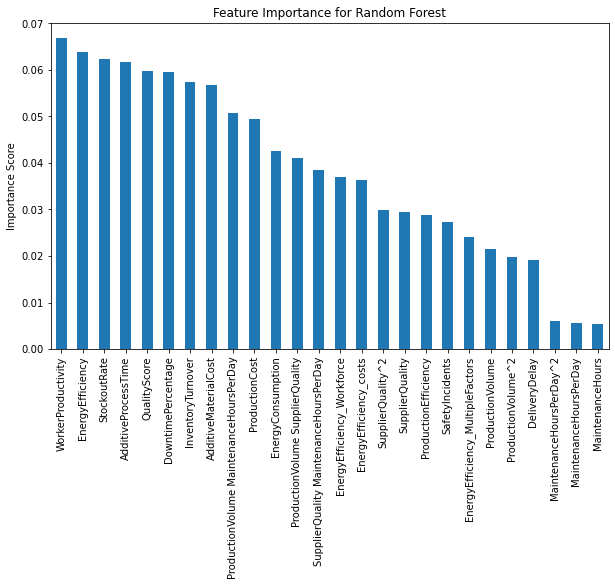


Feature Importance for LightGBM:
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5443
[LightGBM] [Info] Number of data points in the train set: 2592, number of used features: 26
[LightGBM] [Info] Start training from score 2.716228
StockoutRate                               100
AdditiveProcessTime                         83
WorkerProductivity                          71
ProductionVolume SupplierQuality            68
EnergyConsumption                           61
ProductionCost                              49
ProductionEfficiency                        47
DowntimePercentage                          47
SafetyIncidents                             47
ProductionVolume                            46
QualityScore                                46
ProductionVolume Maintenance

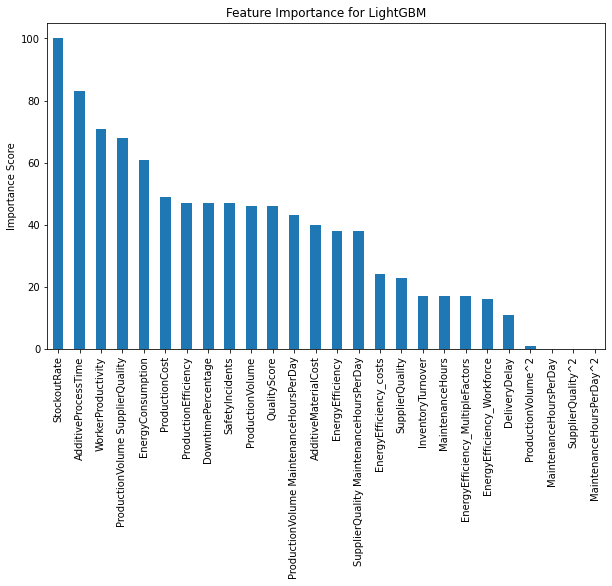

In [16]:
# Feature Importance for Random Forest
print("\nFeature Importance for Random Forest:")
rf_model = RandomForestRegressor(**random_search_rf.best_params_, random_state=42)
rf_model.fit(X_train, y_train.values.ravel())
feature_importances_rf = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importances_rf)

# Plotting Feature Importance for Random Forest
plt.figure(figsize=(10, 6))
feature_importances_rf.plot(kind='bar', title='Feature Importance for Random Forest')
plt.ylabel('Importance Score')
plt.show()

# Feature Importance for LightGBM
print("\nFeature Importance for LightGBM:")
lgb_model = lgb.LGBMRegressor(**random_search_lgb.best_params_, random_state=42)
lgb_model.fit(X_train, y_train.values.ravel())
feature_importances_lgb = pd.Series(lgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importances_lgb)

# Plotting Feature Importance for LightGBM
plt.figure(figsize=(10, 6))
feature_importances_lgb.plot(kind='bar', title='Feature Importance for LightGBM')
plt.ylabel('Importance Score')
plt.show()

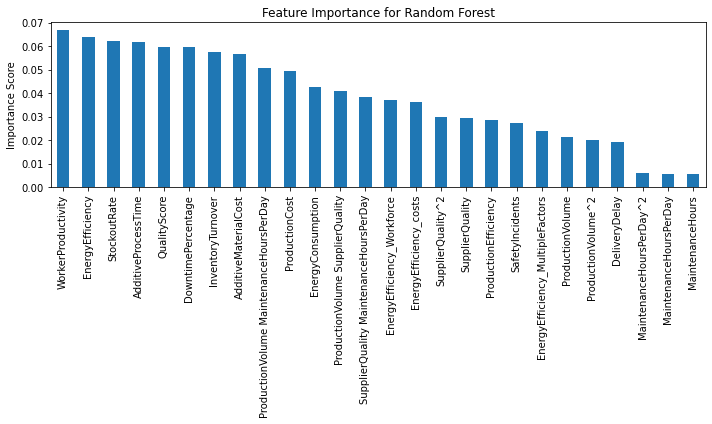

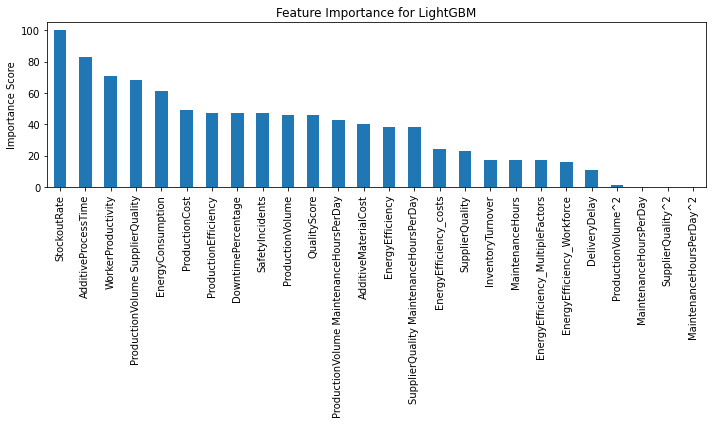

In [30]:
# Save the Random Forest Feature Importance plot
plt.figure(figsize=(10, 6))
feature_importances_rf.plot(kind='bar', title='Feature Importance for Random Forest')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.savefig('Figures/Figures_Results/feature_importance_rf.png', dpi=300)

# Save the LightGBM Feature Importance plot
plt.figure(figsize=(10, 6))
feature_importances_lgb.plot(kind='bar', title='Feature Importance for LightGBM')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.savefig('Figures/Figures_Results/feature_importance_lgb.png', dpi=300)


## Model Training Random Forest and LightGBM (with most important features)

#### Top Features Dataset

In [17]:
# Selecting top features from Random Forest and LightGBM separately
top_features_rf = feature_importances_rf[feature_importances_rf > 0.04].index.tolist()  # Keeping features with importance > 0.04 for RF
print("\nTop features selected from Random Forest:")
print(top_features_rf)

top_features_lgb = feature_importances_lgb[feature_importances_lgb > 40].index.tolist()  # Keeping features with importance > 40 for LightGBM
print("\nTop features selected from LightGBM:")
print(top_features_lgb)

# Creating separate datasets for Random Forest and LightGBM
X_train_rf_top_features = X_train[top_features_rf]
X_train_lgb_top_features = X_train[top_features_lgb]


Top features selected from Random Forest:
['WorkerProductivity', 'EnergyEfficiency', 'StockoutRate', 'AdditiveProcessTime', 'QualityScore', 'DowntimePercentage', 'InventoryTurnover', 'AdditiveMaterialCost', 'ProductionVolume MaintenanceHoursPerDay', 'ProductionCost', 'EnergyConsumption', 'ProductionVolume SupplierQuality']

Top features selected from LightGBM:
['StockoutRate', 'AdditiveProcessTime', 'WorkerProductivity', 'ProductionVolume SupplierQuality', 'EnergyConsumption', 'ProductionCost', 'ProductionEfficiency', 'DowntimePercentage', 'SafetyIncidents', 'ProductionVolume', 'QualityScore', 'ProductionVolume MaintenanceHoursPerDay']


#### Retraining Models (based on top features per model)

In [18]:
# Retrain Random Forest and LightGBM on their respective reduced datasets
reduced_models_rf_lgb = {
    'Random Forest (Top Features)': RandomForestRegressor(random_state=42),
    'LightGBM (Top Features)': lgb.LGBMRegressor(random_state=42)
}

# Training and evaluating Random Forest on reduced dataset with top features
print("\nTraining and evaluating Random Forest on reduced dataset with top features...")
results_rf_reduced = train_and_evaluate({'Random Forest (Top Features)': reduced_models_rf_lgb['Random Forest (Top Features)']}, X_train_rf_top_features, y_train)

# Training and evaluating LightGBM on reduced dataset with top features
print("\nTraining and evaluating LightGBM on reduced dataset with top features...")
results_lgb_reduced = train_and_evaluate({'LightGBM (Top Features)': reduced_models_rf_lgb['LightGBM (Top Features)']}, X_train_lgb_top_features, y_train)

# Display results of retrained Random Forest and LightGBM on their respective reduced datasets
print("\nResults on Reduced Dataset with Top Features for Random Forest:")
for model_name, metrics in results_rf_reduced.items():
    print(f"{model_name}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, R²={metrics['R²']:.4f}")

print("\nResults on Reduced Dataset with Top Features for LightGBM:")
for model_name, metrics in results_lgb_reduced.items():
    print(f"{model_name}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, R²={metrics['R²']:.4f}")


Training and evaluating Random Forest on reduced dataset with top features...
Training Random Forest (Top Features) with cross-validation...

Training and evaluating LightGBM on reduced dataset with top features...
Training LightGBM (Top Features) with cross-validation...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2814
[LightGBM] [Info] Number of data points in the train set: 2073, number of used features: 12
[LightGBM] [Info] Start training from score 2.722736
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2814
[LightGBM] [Info] Number of d

### Hyperparameter Tuning using GridSearch on best performing models (SVR v1.0 & LightGBM v3.0)

##### Apply GridSearch on LightGBM v3.0

In [19]:
# Define parameter grid for GridSearch
param_grid_lgb = {
    'num_leaves': [20, 31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20]
}

# Set up GridSearch for LightGBM
print("\nPerforming GridSearch for LightGBM...")
grid_search_lgb = GridSearchCV(estimator=lgb.LGBMRegressor(random_state=42), param_grid=param_grid_lgb, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

grid_search_lgb.fit(X_train, y_train.values.ravel())

# Best parameters for LightGBM
grid_search_best_params_lgb = grid_search_lgb.best_params_
print("\nBest parameters for LightGBM after GridSearch:")
print(grid_search_best_params_lgb)


Performing GridSearch for LightGBM...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5443
[LightGBM] [Info] Number of data points in the train set: 2592, number of used features: 26
[LightGBM] [Info] Start training from score 2.716228

Best parameters for LightGBM after GridSearch:
{'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 20}


##### Retraining LightGBM using results of Gridsearch

In [20]:
# Retrain LightGBM with best parameters from GridSearch
best_lgb_model = lgb.LGBMRegressor(**grid_search_best_params_lgb, random_state=42)

print("\nTraining LightGBM with best parameters from GridSearch...")
results_lgb_final = train_and_evaluate({'LightGBM (Best Parameters)': best_lgb_model}, X_train, y_train)

# Display results of LightGBM after final training
print("\nResults of LightGBM with Best Parameters from GridSearch:")
for model_name, metrics in results_lgb_final.items():
    print(f"{model_name}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, R²={metrics['R²']:.4f}")


Training LightGBM with best parameters from GridSearch...
Training LightGBM (Best Parameters) with cross-validation...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5443
[LightGBM] [Info] Number of data points in the train set: 2073, number of used features: 26
[LightGBM] [Info] Start training from score 2.722736
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5443
[LightGBM] [Info] Number of data points in the train set: 2073, number of used features: 26
[LightGBM] [Info] Start training from score 2.723380
[LightGBM] [Warning] Found whitespace 

##### Apply GridSearch on SVR v1.0 (with original data)

In [21]:
# Load original traindata
X_train_original = pd.read_csv('Train_Test_Data/X_train_original.csv')
y_train_original = pd.read_csv('Train_Test_Data/y_train_original.csv')

# Define parameter grid for GridSearch for SVR
param_grid_svr = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['rbf', 'poly', 'linear']
}

# Set up GridSearch for SVR
print("\nPerforming GridSearch for SVR...")
grid_search_svr = GridSearchCV(estimator=SVR(), param_grid=param_grid_svr, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

grid_search_svr.fit(X_train_original, y_train_original.values.ravel())

# Best parameters for SVR
grid_search_best_params_svr = grid_search_svr.best_params_
print("\nBest parameters for SVR after GridSearch:")
print(grid_search_best_params_svr)


Performing GridSearch for SVR...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best parameters for SVR after GridSearch:
{'C': 1, 'epsilon': 0.5, 'kernel': 'poly'}


##### Retraining SVR using results of Gridsearch

In [22]:
# Retrain SVR and with best parameters from GridSearch
best_svr_model = SVR(**grid_search_best_params_svr)

# Train and evaluate SVR and LightGBM with best parameters
print("\nTraining SVR with best parameters from GridSearch...")
results_final = train_and_evaluate({'SVR (Best Parameters)': best_svr_model}, X_train_original, y_train_original)

# Display results of SVR after final training
print("\nResults of SVR with Best Parameters from GridSearch:")
for model_name, metrics in results_final.items():
    print(f"{model_name}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, R²={metrics['R²']:.4f}")


Training SVR with best parameters from GridSearch...
Training SVR (Best Parameters) with cross-validation...

Results of SVR with Best Parameters from GridSearch:
SVR (Best Parameters): MAE=1.1390, RMSE=1.3118, R²=-0.0027


# Final Evaluation:

#### Applying best version of each model (with best set of features and best set of parameters) to the test set

In [23]:
# Load the test data
X_test = pd.read_csv('Train_Test_Data/X_test_engineered.csv')
y_test = pd.read_csv('Train_Test_Data/y_test_engineered.csv')

X_test.head()

,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,QualityScore,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,...,ProductionVolume^2,ProductionVolume SupplierQuality,ProductionVolume MaintenanceHoursPerDay,SupplierQuality^2,SupplierQuality MaintenanceHoursPerDay,MaintenanceHoursPerDay^2,ProductionEfficiency,EnergyEfficiency_MultipleFactors,EnergyEfficiency_costs,EnergyEfficiency_Workforce
0,-1.488492,0.819689,-0.977006,3,79.750780,13,-0.486557,-0.885086,0.033026,0.332231,...,-1.172878,-1.512909,-0.823493,-0.976473,0.104055,-0.061200,-0.693131,-0.694338,-1.157627,1.607813
1,-1.191193,1.483145,0.133332,5,88.679076,21,1.692213,-0.229412,0.044703,-0.204603,...,-1.068323,-1.172814,-0.258926,0.101644,1.407486,1.615131,-0.943310,-0.944616,-0.631341,-0.525404
2,1.343477,0.275102,-1.161563,0,85.870998,6,0.178101,-0.083556,0.065364,1.666701,...,1.504050,1.081199,-0.171382,-1.148031,-0.857200,-0.880876,1.107555,1.110057,-0.683268,0.429870
3,0.729820,0.551244,-0.163076,3,71.264024,14,1.221629,0.310304,0.071165,-0.210240,...,0.605202,0.696700,0.792390,-0.193878,0.345765,0.105201,0.007568,0.007818,-0.329347,-0.539220
4,0.786993,-0.277624,-0.382948,4,99.945915,4,0.046159,-0.603097,0.043963,1.223731,...,0.681495,0.712596,-0.635564,-0.409464,-1.096543,-1.004136,0.608456,0.610667,-0.409877,0.258986


In [24]:
# Define/load best parameters RF, SVR and LightGBM
best_params_rf_v3_0 = random_search_rf.best_params_

best_params_svr_v5_0 = grid_search_svr.best_params_

best_params_lightgbm_v3_0 = random_search_lgb.best_params_

# Define/load the best feature set per model
features_LRv3_1 = selected_features_lasso 
features_RFv3_0 = X_train.columns
features_SVRv5_0 = X_train_original.columns
LightGBMv3_0 = X_train.columns

# Matching best feature set per model with test set
features_LRv3_1 = X_test.columns.intersection(selected_features_lasso)
features_RFv3_0 = X_test.columns.intersection(X_train.columns)
features_SVRv5_0 = X_test.columns.intersection(X_train_original.columns)
features_LightGBMv3_0 = X_test.columns.intersection(X_train.columns)

# Load the best model versions and train them
# Linear Regression (baseline) v3.1 (Model with original and engineered features after applying Lasso)
LRv3_1 = LinearRegression()
LRv3_1.fit(X_train[features_LRv3_1], y_train.values.ravel())

# Random Forest v3.0 (Model with original and engineered features after applying RandomizedSearch)
RFv3_0 = RandomForestRegressor(**best_params_rf_v3_0)
RFv3_0.fit(X_train[features_RFv3_0], y_train.values.ravel())

# Support Vector Regression v5.0 (Model with original features after applying GridSearch)
SVRv5_0 = SVR(**best_params_svr_v5_0)
SVRv5_0.fit(X_train[features_SVRv5_0], y_train.values.ravel())

# LightGBM v3.0 (Model with original and engineered features after applying RandomizedSearch)
LightGBMv3_0 = lgb.LGBMRegressor(**best_params_lightgbm_v3_0)
LightGBMv3_0.fit(X_train[features_LightGBMv3_0], y_train.values.ravel())


# Applying models to the test set and evaluating performance
def evaluate_model(model, X_test, y_test, model_name):
    # Predict using the test set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Print results
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Evaluate all models on the test set
print("\nFinal Evaluation on Test Set:")
evaluate_model(LRv3_1, X_test[features_LRv3_1], y_test, "Linear Regression v3.1 (Lasso)")
evaluate_model(RFv3_0, X_test[features_RFv3_0], y_test, "Random Forest v3.0 (RandomizedSearch)")
evaluate_model(SVRv5_0, X_test[features_SVRv5_0], y_test, "Support Vector Regression v5.0 (GridSearch)")
evaluate_model(LightGBMv3_0, X_test[features_LightGBMv3_0], y_test, "LightGBM v3.0 (RandomizedSearch)")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5443
[LightGBM] [Info] Number of data points in the train set: 2592, number of used features: 26
[LightGBM] [Info] Start training from score 2.716228

Final Evaluation on Test Set:
Linear Regression v3.1 (Lasso) - MAE: 1.1385, RMSE: 1.3171, R²: -0.0314
Random Forest v3.0 (RandomizedSearch) - MAE: 1.1304, RMSE: 1.3064, R²: -0.0148
Support Vector Regression v5.0 (GridSearch) - MAE: 1.1367, RMSE: 1.3141, R²: -0.0267
LightGBM v3.0 (RandomizedSearch) - MAE: 1.1321, RMSE: 1.3080, R²: -0.0173


In [25]:
# Baseline Linear Regression Model v1.0 (Model with original features)
X_test_original = pd.read_csv('Train_Test_Data/X_test_original.csv')
y_test_original = pd.read_csv('Train_Test_Data/y_test_original.csv')

# Load the baseline model
LR_baseline_v1_0 = LinearRegression()
LR_baseline_v1_0.fit(X_train_original, y_train_original.values.ravel())

# Evaluate the baseline Linear Regression model
evaluate_model(LR_baseline_v1_0, X_test_original, y_test_original, "Linear Regression Baseline v1.0 (Original Features)")

Linear Regression Baseline v1.0 (Original Features) - MAE: 1.1383, RMSE: 1.3171, R²: -0.0315


# Error Analysis


Residual Analysis on Test Set:


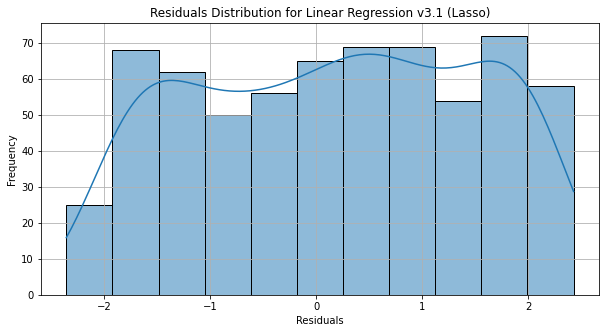

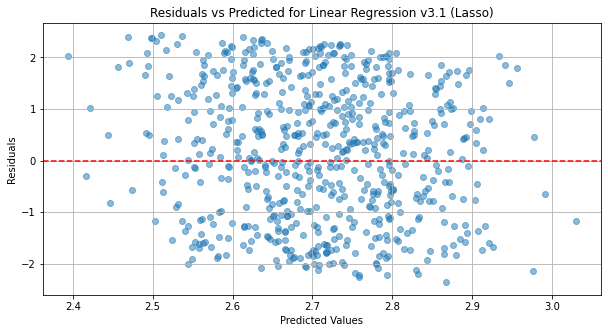

Linear Regression v3.1 (Lasso) - Mean Residual: 0.1734, Std of Residuals: 1.3056


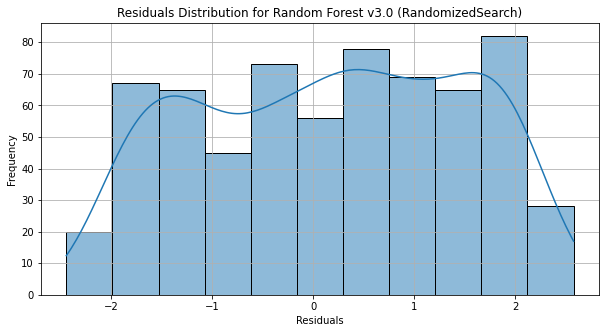

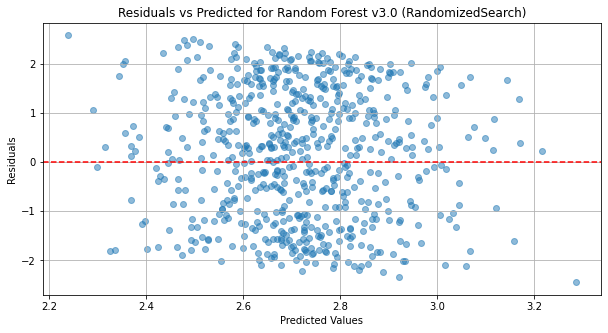

Random Forest v3.0 (RandomizedSearch) - Mean Residual: 0.1672, Std of Residuals: 1.2957


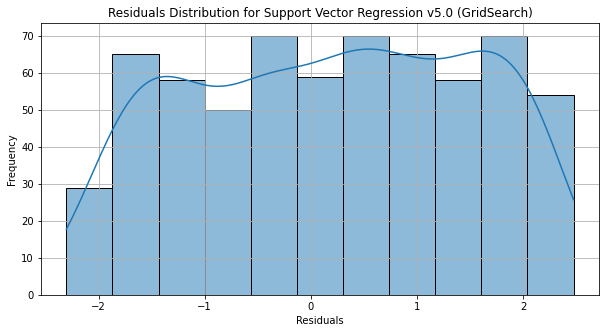

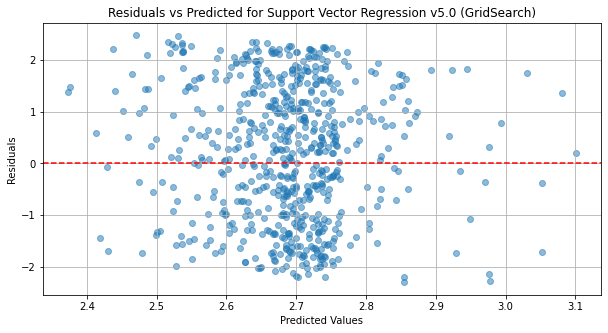

Support Vector Regression v5.0 (GridSearch) - Mean Residual: 0.1941, Std of Residuals: 1.2996


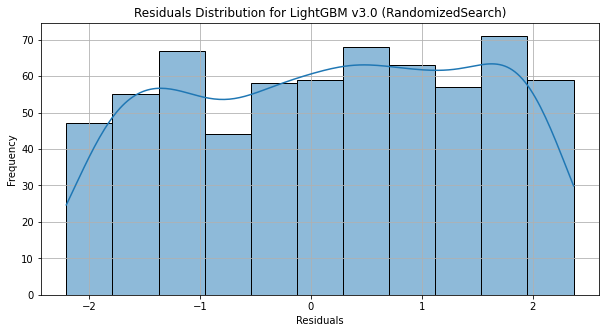

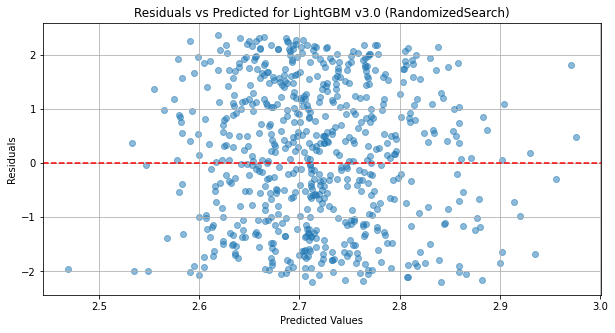

LightGBM v3.0 (RandomizedSearch) - Mean Residual: 0.1642, Std of Residuals: 1.2977


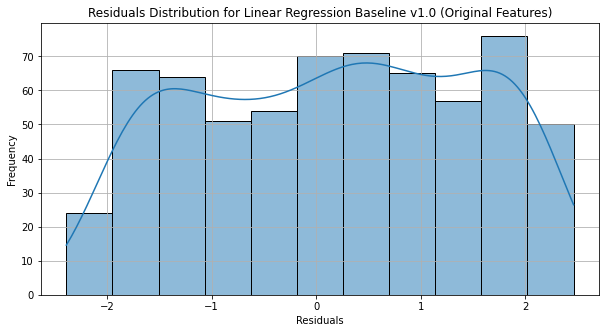

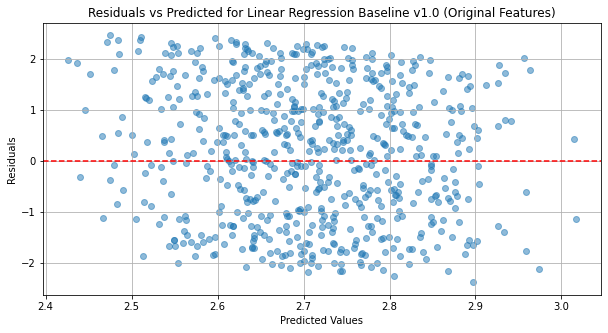

Linear Regression Baseline v1.0 (Original Features) - Mean Residual: 0.1731, Std of Residuals: 1.3057


In [26]:
import seaborn as sns

# Function to perform residual analysis
def residual_analysis(model, X_test, y_test, model_name):
    # Predict with the model
    y_pred = model.predict(X_test)
    
    # Calculate residuals
    residuals = y_test.values.ravel() - y_pred
    
    # Create a histogram of the residuals
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, kde=True)
    plt.title(f'Residuals Distribution for {model_name}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # Create a scatter plot of residuals vs predictions
    plt.figure(figsize=(10, 5))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.title(f'Residuals vs Predicted for {model_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # Print key statistics of the residuals
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)
    print(f"{model_name} - Mean Residual: {mean_residual:.4f}, Std of Residuals: {std_residual:.4f}")

# Residual analysis for each model
print("\nResidual Analysis on Test Set:")
residual_analysis(LRv3_1, X_test[features_LRv3_1], y_test, "Linear Regression v3.1 (Lasso)")
residual_analysis(RFv3_0, X_test[features_RFv3_0], y_test, "Random Forest v3.0 (RandomizedSearch)")
residual_analysis(SVRv5_0, X_test[features_SVRv5_0], y_test, "Support Vector Regression v5.0 (GridSearch)")
residual_analysis(LightGBMv3_0, X_test[features_LightGBMv3_0], y_test, "LightGBM v3.0 (RandomizedSearch)")
residual_analysis(LR_baseline_v1_0, X_test_original, y_test_original, "Linear Regression Baseline v1.0 (Original Features)")


In [35]:
# Function to create and save residual plots
def save_residual_plots(model, X_test, y_test, model_name):
    # Predict with the model
    y_pred = model.predict(X_test)
    residuals = y_test.values.ravel() - y_pred
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram of residuals
    sns.histplot(residuals, kde=True, ax=axes[0])
    axes[0].set_title(f'Residuals Distribution for {model_name}', fontsize=16)
    axes[0].set_xlabel('Residuals', fontsize=14)
    axes[0].set_ylabel('Frequency', fontsize=14)
    
    # Residuals vs Predicted scatter plot
    axes[1].scatter(y_pred, residuals, alpha=0.5)
    axes[1].axhline(0, color='r', linestyle='--')
    axes[1].set_title(f'Residuals vs Predicted for {model_name}', fontsize=16)
    axes[1].set_xlabel('Predicted Values', fontsize=14)
    axes[1].set_ylabel('Residuals', fontsize=14)
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(f"{model_name}_residual_analysis.png")
    plt.close()

# Save residual plots for each model
save_residual_plots(LRv3_1, X_test[features_LRv3_1], y_test, "LR v3.1 (Lasso)")
save_residual_plots(RFv3_0, X_test[features_RFv3_0], y_test, "RF v3.0 (RandomizedSearch)")
save_residual_plots(SVRv5_0, X_test[features_SVRv5_0], y_test, "SVR v5.0 (GridSearch)")
save_residual_plots(LightGBMv3_0, X_test[features_LightGBMv3_0], y_test, "LightGBM v3.0 (RandomizedSearch)")
save_residual_plots(LR_baseline_v1_0, X_test_original, y_test_original, "LR Baseline v1.0 (Original Features)")



### Normality test of residuals

In [29]:
from scipy.stats import shapiro, kstest # Source
import numpy as np
import pandas as pd

# Function to evaluate normality of residuals
def normality_test(model, X_test, y_test, model_name):
    # Predict using the test set
    y_pred = model.predict(X_test)

    # Convert y_test and y_pred to numpy arrays to ensure compatibility
    y_test = np.array(y_test).flatten()  # Ensures y_test is a one-dimensional array
    y_pred = np.array(y_pred).flatten()  # Ensures y_pred is a one-dimensional array

    # Debugging print statements to ensure compatibility
    print(f"Shape of y_test: {y_test.shape}, Shape of y_pred: {y_pred.shape}")

    # Calculate residuals
    try:
        residuals = y_test - y_pred
    except ValueError as e:
        print(f"Error while calculating residuals: {e}")
        return

    # Ensure residuals are in the correct shape and type
    residuals = pd.Series(residuals)  # Convert residuals to a Pandas Series

    # Perform Shapiro-Wilk test for normality
    shapiro_test = shapiro(residuals)

    # Perform Kolmogorov-Smirnov test for normality
    ks_test = kstest(residuals, 'norm', args=(residuals.mean(), residuals.std()))

    # Print results
    print(f"\nNormality Test Results for {model_name}:")
    print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")
    print(f"Kolmogorov-Smirnov Test: Statistic={ks_test.statistic:.4f}, p-value={ks_test.pvalue:.4f}")

    # Interpretation
    if shapiro_test.pvalue > 0.05 and ks_test.pvalue > 0.05:
        print("Residuals are likely normally distributed (based on Shapiro-Wilk and KS tests).")
    else:
        print("Residuals are likely not normally distributed (based on Shapiro-Wilk and/or KS tests).")

# Apply the normality tests to all models
print("\nNormality Tests for Residuals:")
normality_test(LRv3_1, X_test[features_LRv3_1], y_test, "Linear Regression v3.1 (Lasso)")
normality_test(RFv3_0, X_test[features_RFv3_0], y_test, "Random Forest v3.0 (RandomizedSearch)")
normality_test(SVRv5_0, X_test[features_SVRv5_0], y_test, "Support Vector Regression v5.0 (GridSearch)")
normality_test(LightGBMv3_0, X_test[features_LightGBMv3_0], y_test, "LightGBM v3.0 (RandomizedSearch)")
normality_test(LR_baseline_v1_0, X_test_original, y_test_original, "Linear Regression Baseline v1.0 (Original Features)")





Normality Tests for Residuals:
Shape of y_test: (648,), Shape of y_pred: (648,)

Normality Test Results for Linear Regression v3.1 (Lasso):
Shapiro-Wilk Test: Statistic=0.9553, p-value=0.0000
Kolmogorov-Smirnov Test: Statistic=0.0671, p-value=0.0056
Residuals are likely not normally distributed (based on Shapiro-Wilk and/or KS tests).
Shape of y_test: (648,), Shape of y_pred: (648,)

Normality Test Results for Random Forest v3.0 (RandomizedSearch):
Shapiro-Wilk Test: Statistic=0.9572, p-value=0.0000
Kolmogorov-Smirnov Test: Statistic=0.0697, p-value=0.0035
Residuals are likely not normally distributed (based on Shapiro-Wilk and/or KS tests).
Shape of y_test: (648,), Shape of y_pred: (648,)

Normality Test Results for Support Vector Regression v5.0 (GridSearch):
Shapiro-Wilk Test: Statistic=0.9555, p-value=0.0000
Kolmogorov-Smirnov Test: Statistic=0.0701, p-value=0.0032
Residuals are likely not normally distributed (based on Shapiro-Wilk and/or KS tests).
Shape of y_test: (648,), Shape